# Preparing

In [2]:
import pandas as pd
import re, string
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
!pip install tensorflow-addons


KAGGLE = False  # True if run on Kaggle Kernel, False if run on Google Colab
SHOW_PLOT = True  # True to show word plot (more execution time)


nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_colwidth', 2)

if KAGGLE:
    DATA_DIR = "/kaggle/working"
else:
    DATA_DIR = "/content/drive/Shareddrives/AML/embeddings"

if KAGGLE:
    import zipfile
    with zipfile.ZipFile("/kaggle/input/quora-insincere-questions-classification/embeddings.zip", 'r') as f:
        f.extractall(".")
    !cp "/kaggle/input/quora-insincere-questions-classification/train.csv" .
    !cp "/kaggle/input/quora-insincere-questions-classification/test.csv" .

     |████████████████████████████████| 1.1 MB 1.6 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data analyzing

In [3]:
train_data_path = os.path.join(DATA_DIR, "train.csv")

df = pd.read_csv(train_data_path)
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [4]:
df.groupby("target").size()

target
0    1225312
1    80810  
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


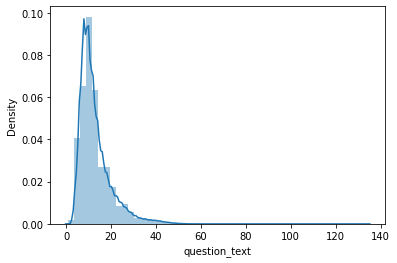

In [5]:
# Word distribution by length
import seaborn as sns

lengths = df['question_text'].apply(lambda x: len(x.split()))
sns.distplot(lengths)

In [6]:
# Function to show word distribution by frequency
from nltk.probability import FreqDist

def show_words_freq_plot(frame):
    def get_token(fr):
        for st in fr:
            for token in word_tokenize(st):
                yield token
    fd = FreqDist(get_token(frame))
    fd.plot(30)

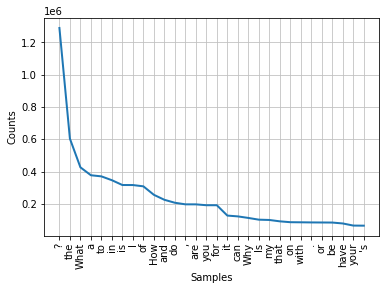

In [7]:
# Word distribution by frequency for sincere questions
if SHOW_PLOT:
    show_words_freq_plot(df[df['target'] == 0]['question_text'])

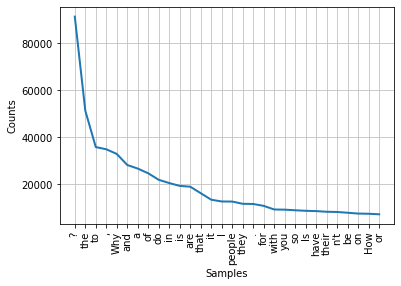

In [8]:
# Word distribution by frequency for insincere questions
if SHOW_PLOT:
    show_words_freq_plot(df[df['target'] == 1]['question_text'])

# Data preprocessing

In [9]:
stop_words = list(stopwords.words('english'))


def preprocess_text(text):
    # Remove icon
    icon_re = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = icon_re.sub(r'', text)

    # Remove punctuation
    punctuation = string.punctuation.replace("-", "").replace("'", "")
    text = "".join([i if i not in punctuation else " " for i in text])

    # Remove number
    text = re.sub(r'\d+', '', text)

    # Lowercase text
    text = text.lower()

    # Remove duplicated characters
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Remove \n and strip
    text = text.replace("\n", " ").strip()

    # Remove double space
    text = re.sub(" +", " ", text)

    # Remove stopwords
    word_token = word_tokenize(text)
    filtered = [w for w in word_token if not w in stop_words]
    text = " ".join(filtered)

    # Return
    return text

In [10]:
df['preprocessed'] = df['question_text'].apply(lambda x: preprocess_text(x))
df.head()

,qid,question_text,target,preprocessed
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,quebec nationalists see province nation
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,adopted dog would encourage people adopt shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,velocity affect time velocity affect space geometry
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,otto von guericke used magdeburg hemispheres
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,convert montra helicon mountain bike changing tyres


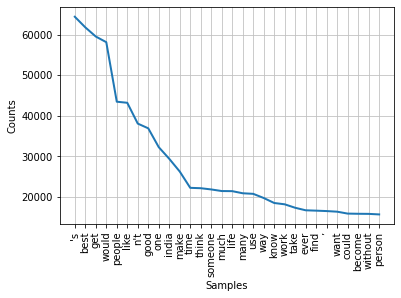

In [11]:
# Word distribution by frequency for sincere questions
if SHOW_PLOT:
    show_words_freq_plot(df[df['target'] == 0].astype('str')['preprocessed'])

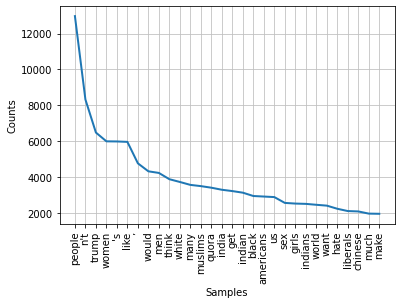

In [12]:
# Word distribution by frequency for insincere questions
if SHOW_PLOT:
    show_words_freq_plot(df[df['target'] == 1].astype('str')['preprocessed'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


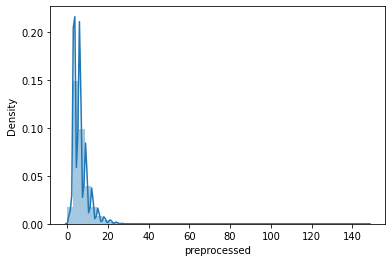

In [13]:
# Word distribution by length
import seaborn as sns

lengths = df['preprocessed'].astype('str').apply(lambda x: len(x.split()))
sns.distplot(lengths)

In [14]:
if not KAGGLE:
    df.to_csv(os.path.join(DATA_DIR, 'preprocessed.csv'), columns=['qid', 'preprocessed', 'target'], index=False)

# Training

In [15]:
if not KAGGLE:
    df = pd.read_csv(os.path.join(DATA_DIR, 'preprocessed.csv'))
df.head()

,qid,preprocessed,target
0,00002165364db923c7e6,quebec nationalists see province nation,0
1,000032939017120e6e44,adopted dog would encourage people adopt shop,0
2,0000412ca6e4628ce2cf,velocity affect time velocity affect space geometry,0
3,000042bf85aa498cd78e,otto von guericke used magdeburg hemispheres,0
4,0000455dfa3e01eae3af,convert montra helicon mountain bike changing tyres,0


In [16]:
X_data = df['preprocessed'].astype('str')
y_data = df['target']
print(X_data.shape)
print(y_data.shape)

(1306122,)
(1306122,)


In [17]:
# Undersampling (ratio: 1:1)

data_one = df[df['target'] == 1]
data_zero = df[df['target'] == 0]
data_zero_new = data_zero.sample(data_one.shape[0])
data = pd.concat([data_one, data_zero_new])

X_data = data['preprocessed'].astype('str')
y_data = data['target']
print(X_data.shape)
print(y_data.shape)

(161620,)
(161620,)


In [18]:
# Tokenize all dataset
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100  # Max word count in sentences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)
X_data_padded = pad_sequences(sequences, maxlen=maxlen)

word_index = tokenizer.word_index

In [19]:
# Split train-validation dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data_padded, y_data, test_size=0.2, stratify=y_data, random_state=2)

In [20]:
# Prepare embedding layer from word embedding
# (develop from this tutorial: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
word_path = os.path.join(DATA_DIR, "glove.840B.300d/glove.840B.300d.txt")

embeddings_index = {}
with open(word_path, 'r') as f:
    for line in f:
        values = line.split()
        word = " ".join(values[:-300])
        coefs = np.array(values[-300:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

from keras.layers import Embedding
embedding_layer = Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,))

In [21]:
# Build model
from keras.layers import Dense, Input, LSTM, Bidirectional
from keras.models import Model
import tensorflow_addons as tfa

ipt = Input(shape=(maxlen,), dtype='int32')
x = embedding_layer(ipt)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64))(x)
x = Dense(64, activation='relu')(x)
opt = Dense(1, activation='sigmoid')(x)


f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)  # Use f1-score for training with imbalanced dataset

model = Model(ipt, opt)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1, 'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          18393000  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65    

In [22]:
# Start training with some earlystopping and reduceLR
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, mode='auto')

history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[es, rl])

Epoch 1/10
1011/1011 [==============================] - 120s 107ms/step - loss: 0.2984 - f1_score: 0.8824 - accuracy: 0.8807 - val_loss: 0.2721 - val_f1_score: 0.8926 - val_accuracy: 0.8930 - lr: 0.0010
Epoch 2/10
1011/1011 [==============================] - 106s 105ms/step - loss: 0.2570 - f1_score: 0.9010 - accuracy: 0.9000 - val_loss: 0.2575 - val_f1_score: 0.8982 - val_accuracy: 0.8992 - lr: 0.0010
Epoch 3/10
1011/1011 [==============================] - 105s 104ms/step - loss: 0.2320 - f1_score: 0.9108 - accuracy: 0.9099 - val_loss: 0.2571 - val_f1_score: 0.8973 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 4/10
1011/1011 [==============================] - 106s 105ms/step - loss: 0.2073 - f1_score: 0.9212 - accuracy: 0.9204 - val_loss: 0.2547 - val_f1_score: 0.9050 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 5/10
1011/1011 [==============================] - 106s 105ms/step - loss: 0.1784 - f1_score: 0.9329 - accuracy: 0.9321 - val_loss: 0.2725 - val_f1_score: 0.8985 - val_accuracy: 0.898

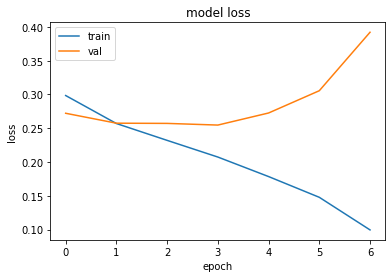

In [23]:
# Graph of model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

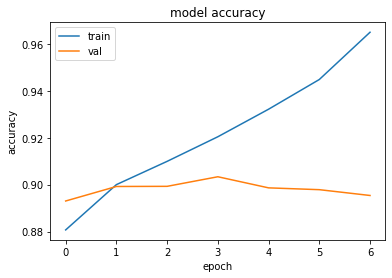

In [24]:
# Graph of training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

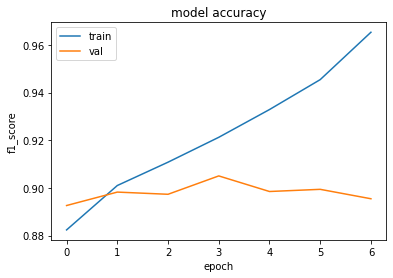

In [25]:
# Graph of f1-score
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

# Submission



In [26]:
test_data_path = os.path.join(DATA_DIR, "test.csv")

df_test = pd.read_csv(test_data_path)
df_test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arrogant when they get just a little bit of wealth and power?
1,00002bd4fb5d505b9161,When should I apply for RV college of engineering and BMS college of engineering? Should I wait for the COMEDK result or am I supposed to apply before the result?
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitioner?
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [27]:
t_preprocessed = df_test['question_text'].apply(lambda x: preprocess_text(x))
t_sequences = tokenizer.texts_to_sequences(t_preprocessed)
t_data = pad_sequences(t_sequences, maxlen=maxlen)

t_pred = model.predict(t_data).round().astype('int32').flatten()

In [28]:
submit_path = "submission.csv" if KAGGLE else os.path.join(DATA_DIR, "submission.csv")
sm_df = pd.DataFrame({"qid": df_test['qid'], "prediction": t_pred})
sm_df.to_csv(submit_path, index=False)
sm_df.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,1
